In [1]:
import os
import glob
import pandas as pd
import numpy as np
##rename to Temporal Split

# Base directory
datadir = "/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove"
sites = ['cheeca_flkeys','lbcaye_bbr', 'sanagustin_mexico','northpoint_lizard']
#sample_sites= for each site 1 timestamp picked at random

# Variables to store file paths and their labels
filepaths = []

# Collect filepaths from every image that we have
for site in sites:    
    # Get all bleached and healthy files for the current site
    filepaths_site = glob.glob(os.path.join(datadir, site, '**/*.tif'), recursive=True)
    # Add filepaths
    filepaths.extend(filepaths_site)

# Check if files were collected
assert filepaths, "No files found. Please check your directory structure and file paths."

# Create a DataFrame
df = pd.DataFrame({
    'filepath': filepaths,
})

# Extract components from the file path
df['site'] = df['filepath'].apply(lambda x: x.split('/')[6])  # Extract site
df['label'] = df['filepath'].apply(lambda x: x.split('/')[7])  # Extract label (bleached/healthy)
df['date'] = df['filepath'].apply(lambda x: x.split('/')[9])  # Extract date
df['filename'] = df['filepath'].apply(lambda x: os.path.basename(x))  # Extract filename

# Rearrange the columns
df = df[['site', 'label', 'date', 'filename', 'filepath']]

# Debugging: Check the DataFrame
print(df.head())
df['image_id'] = range(len(df))
# Save all filepaths to CSV
output_csv_path = "/home/Mariam/codes/ct_classifier/runs/resnet18/split_temporal/all.csv"
df.to_csv(output_csv_path, index=False)
print(f"CSV file saved to: {output_csv_path}")

# Start creating the data splits


            site    label      date    filename  \
0  cheeca_flkeys  healthy  20230504  loc005.tif   
1  cheeca_flkeys  healthy  20230504  loc002.tif   
2  cheeca_flkeys  healthy  20230504  loc003.tif   
3  cheeca_flkeys  healthy  20230504  loc004.tif   
4  cheeca_flkeys  healthy  20230504  loc006.tif   

                                            filepath  
0  /mnt/class_data/group3_remotesensing/mariamaya...  
1  /mnt/class_data/group3_remotesensing/mariamaya...  
2  /mnt/class_data/group3_remotesensing/mariamaya...  
3  /mnt/class_data/group3_remotesensing/mariamaya...  
4  /mnt/class_data/group3_remotesensing/mariamaya...  
CSV file saved to: /home/Mariam/codes/ct_classifier/runs/resnet18/split_temporal/all.csv


In [2]:
# Initialize list of dictionaries to store filepaths 
#  of healthy and bleached images
val_filepaths = {
    'bleached': [],
    'healthy': []
}
test_filepaths = {
    'bleached': [],
    'healthy': []
}
train_filepaths = {
    'bleached': [],
    'healthy': []
}

excluded_filepaths = []

for split_filepaths in [val_filepaths, test_filepaths]:
    # Exclude all filepaths that have already been used for other splits
    if excluded_filepaths:
        df_sub = df[~(df.filepath.isin(excluded_filepaths))]
    else:
        df_sub = df
    
    # Select one date at random from every site
    for label in ['healthy', 'bleached']:
        for site in sites:
            # Within all healthy or bleached images, get all dates for the selected site
            dates_at_site = df_sub[(df_sub.site==site) & (df_sub.label==label)].date.unique()
            # Select one random date within those
            random_date = np.random.choice(dates_at_site)
            # Get filepaths of all tile locations within selected site and date
            filepaths_at_site_date = df_sub[(df_sub.site==site) & (df_sub.date==random_date)].filepath
            # Add filepaths to list
            split_filepaths[label].extend(filepaths_at_site_date)
        
        # Add filepaths that we just selected for the test or val split to the list
        # of excluded files
        excluded_filepaths.extend(split_filepaths[label])

# Move all else into train split
df_train = df[~(df.filepath.isin(excluded_filepaths))]
for label in ['healthy', 'bleached']:
    train_filepaths[label] = list(df_train[df_train.label==label].filepath.values)

In [3]:
# todo: debug case in which there s a site that has less than 3 dates and\or theres an unequal number of bleached\\ healhty images
print('Exlcluded filepaths:',len(excluded_filepaths))
print('Bleached:',len(test_filepaths['bleached']), 'Healthy:', len(test_filepaths['healthy']), 'Bleached:', len(val_filepaths['bleached']), 'Healthy:',len(val_filepaths['healthy']))

print('Bleached train:', len(train_filepaths['bleached']))
print(len(train_filepaths['healthy']))
print(len(df) )
assert (len(df) == len(test_filepaths['bleached']) + 
    len(test_filepaths['healthy']) +len(val_filepaths['bleached']) + 
    len(val_filepaths['healthy']) + len(train_filepaths['bleached']) + 
    len(train_filepaths['healthy'])), 'For some unknown reason the '\
    'total number images in each split does not equal the number of file that we have'

Exlcluded filepaths: 44
Bleached: 11 Healthy: 11 Bleached: 11 Healthy: 11
Bleached train: 70
67
181


In [4]:
train_filepaths[label]

['/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230805/loc005.tif',
 '/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230805/loc002.tif',
 '/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230805/loc003.tif',
 '/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230805/loc004.tif',
 '/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230805/loc006.tif',
 '/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230805/loc001.tif',
 '/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230730/loc005.tif',
 '/mnt/class_data/group3_remotesensing/mariamayad/planet_superdove/cheeca_flkeys/bleached/tiled_360m/20230730/loc002.tif',
 '/mnt/class_dat

In [5]:
train_files = train_filepaths['bleached'] + train_filepaths['healthy']
val_files = val_filepaths['bleached'] + val_filepaths['healthy']+test_filepaths['bleached'] + test_filepaths['healthy']
train_df = df.query('filepath in @train_files')
val_df = df.query('filepath in @val_files')
val_df.to_csv('/home/Mariam/codes/ct_classifier/data/split_temporal/val.csv')
train_df.to_csv('/home/Mariam/codes/ct_classifier/data/split_temporal/train.csv')

In [6]:
#val_df = df.query('filepath in @temp_files')
#train_df = df.query('filepath in @temp_files')
#train_df['image_id'] = range(len(train_df))
val_df = pd.read_csv('/home/Mariam/codes/ct_classifier/data/split_temporal/val.csv')

sites = val_df.site.unique()
image_couples = []
couple_labels = []
for site in sites:
    site_df = val_df[val_df.site==site]
    locations = site_df.filename.unique()
    for location_name in locations:
        #location_name = locations[0]
        location_df = site_df[site_df.filename == location_name]
        healthy_df = location_df[location_df.label=='healthy']
        for i, healthy_entry in healthy_df.iterrows(): # go over all healthy image within a specific location within a specific site
            for j, query_entry in location_df.iterrows(): # match them with any other image from that location in that site (aside from themselves)
                if healthy_entry.image_id != query_entry.image_id:
                    new_couple = (healthy_entry.image_id, query_entry.image_id) # create new image pair of one healthy image and another query
                    new_label = query_entry.label
                    image_couples.append(new_couple)
                    couple_labels.append(new_label)
                



In [7]:
p_ds = pd.DataFrame({'couple':image_couples, 'label':couple_labels})
p_ds.label.value_counts()
#len(set(image_couples))

label
bleached    44
healthy     22
Name: count, dtype: int64

In [8]:
location_df

,Unnamed: 0,site,label,date,filename,filepath,image_id
40,159,northpoint_lizard,healthy,20240105,loc001.tif,/mnt/class_data/group3_remotesensing/mariamaya...,159
41,164,northpoint_lizard,healthy,20230914,loc001.tif,/mnt/class_data/group3_remotesensing/mariamaya...,164
42,166,northpoint_lizard,bleached,20240327,loc001.tif,/mnt/class_data/group3_remotesensing/mariamaya...,166
43,175,northpoint_lizard,bleached,20240319,loc001.tif,/mnt/class_data/group3_remotesensing/mariamaya...,175


In [9]:
import rasterio
import torch
couple = image_couples[0]
idxs = couple
imgs = []
for idx in idxs:
    filepath = val_df.query('image_id==@idx').filepath.values[0]
    with rasterio.open(filepath, mode='r') as ds:
        img = ds.read()
    imgs.append(img)
#filepath2 = val_df.query('image_id==@image_idx2').filepath.values[0]

In [10]:
img = np.concatenate(imgs)
img.shape

(16, 132, 133)

In [11]:
from kornia.augmentation import Resize
r = Resize((120,120),align_corners=False)
r(torch.tensor(img,dtype=torch.float64)).shape

torch.Size([1, 16, 120, 120])

In [12]:
import sys
sys.path.append('/home/Mariam/codes/ct_classifier/ct_classifier')
from dataset import BleachDataset

In [13]:
import yaml
from train import create_dataloader
cfg = yaml.safe_load(open('/home/Mariam/codes/ct_classifier/configs/exp_resnet18.yaml', 'r'))
dl_train = create_dataloader(cfg, split='train')


In [14]:
#batch = next(iter(dl_train))
#batch[0].shape

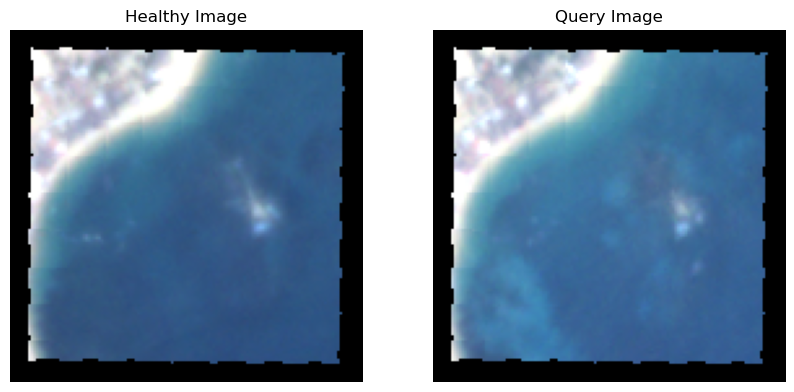

In [15]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Function to mask no-data values and display the image
def mask_nodata_and_show(filepath, nodata_value=None):
    with rasterio.open(filepath, mode='r') as ds:
        img = ds.read([2, 4, 6])  # Read blue, green, and red bands (2, 4, 6)
        
        # Apply the mask based on the no-data value (if provided)
        if nodata_value is None:
            nodata_value = ds.nodata  # Get the default no-data value from the file
            
        mask = np.ma.masked_equal(img, nodata_value)  # Mask the no-data value

        # Normalize and display the image
        img_normalized = np.stack([np.clip((band - band.min()) / (band.max() - band.min()), 0, 1) for band in mask], axis=-1)

        # Display the image
        plt.imshow(img_normalized)
        plt.axis('off')
        plt.show()
        #####

        
# Function to normalize the image band using percentiles (2nd and 98th percentiles)
def percentile_normalize_image_band(band, lower_percentile=2, upper_percentile=98):
    lower = np.percentile(band, lower_percentile)
    upper = np.percentile(band, upper_percentile)
    # Normalize by clipping the values between the lower and upper percentiles and then scaling to [0, 1]
    normalized_band = np.clip((band - lower) / (upper - lower), 0, 1)
    return normalized_band

# Function to read and display the images side by side with custom band order
def show_image_pair(image_paths):
    imgs = []
    for path in image_paths:
        with rasterio.open(path, mode='r') as ds:
            # Read specific bands: blue (2), green (4), red (6)
            blue_band = ds.read(2)  # Band 2: Blue
            green_band = ds.read(4)  # Band 4: Green
            red_band = ds.read(6)  # Band 6: Red

            # Apply percentile normalization to each band
            blue_band = percentile_normalize_image_band(blue_band)
            green_band = percentile_normalize_image_band(green_band)
            red_band = percentile_normalize_image_band(red_band)

            # Stack bands into an RGB image
            #img = np.stack((blue_band, green_band, red_band), axis=-1)
            img = np.stack((red_band, green_band, blue_band), axis=-1)
            imgs.append(img)
    
    # Display images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(imgs[0])
    axes[0].set_title('Healthy Image')
    axes[0].axis('off')
    
    axes[1].imshow(imgs[1])
    axes[1].set_title('Query Image')
    axes[1].axis('off')
    
    plt.show()

# Display the first image couple from image_couples
couple = image_couples[53]
idxs = couple
image_paths = [val_df.query('image_id==@idx').filepath.values[0] for idx in idxs]
show_image_pair(image_paths)